In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile 
from pathlib import Path
import os
from tqdm import tqdm
import sys
import napari
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
from preprocess_tools import aligner, onlypores

# AUX

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

# Load

In [3]:
filename = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\volume_eq_rotated')

data = read_sequence(filename)

Progress: 100%|██████████| 3224/3224 [00:37<00:00, 85.47it/s]


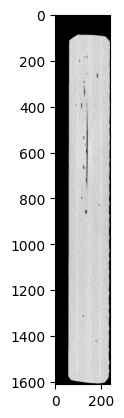

In [4]:
plt.imshow(data[50], cmap='gray')

# Frontwall alignment

In [6]:
mask = onlypores.material_mask(data)

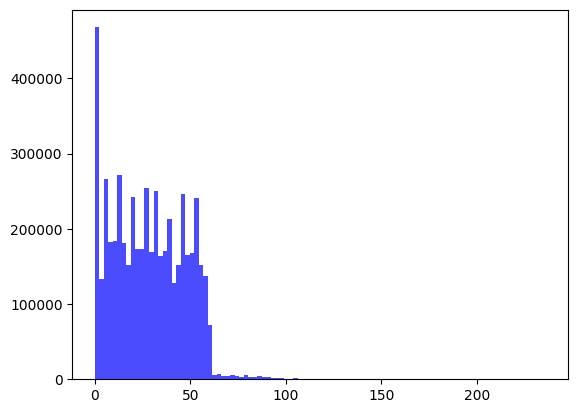

In [38]:
#get the first non zero pixel of each column
first_non_zero = np.argmax(mask, axis=2)

_ = plt.hist(first_non_zero.flatten(), bins=100, color='blue', alpha=0.7)

#detect outliers

Number of outliers: 26405
Outlier value range: 93 to 236


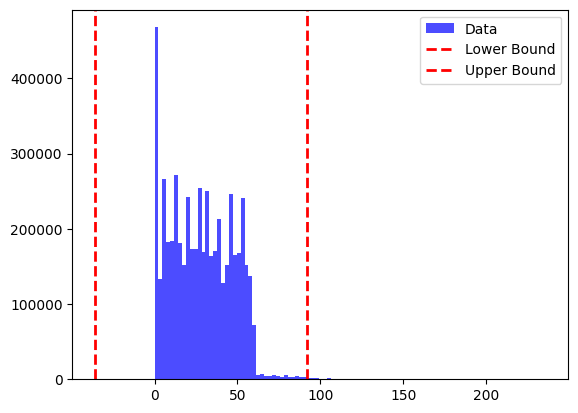

In [45]:
# Detect outliers using the IQR method
flattened = first_non_zero.flatten()
Q1 = np.percentile(flattened, 25)
Q3 = np.percentile(flattened, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = flattened[(flattened < lower_bound) | (flattened > upper_bound)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier value range: {outliers.min() if len(outliers) > 0 else 'N/A'} to {outliers.max() if len(outliers) > 0 else 'N/A'}")

# Visualize outliers on the histogram
plt.hist(flattened, bins=100, color='blue', alpha=0.7, label='Data')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label='Lower Bound')
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2, label='Upper Bound')
plt.legend()
plt.show()

In [22]:
# create the napari viewer
viewer = napari.Viewer()

# add the nuclei image to the viewer
viewer.add_image(first_non_zero)

<Image layer 'first_non_zero' at 0x29a63f2fd90>

c:\Users\alberto.vicente\.conda\envs\prepUTvsXCT\Lib\site-packages\napari\_vispy\layers\scalar_field.py:195: UserWarning: data shape (1, 3224, 1610) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
